In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4 
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]                
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]                                
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                                          
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]           
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [79.8 kB]         
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,802 kB]33m
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,257 kB] 
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]    
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restr

In [5]:
!pip install pyvirtualdisplay

In [6]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [8]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

In [11]:
!pip uninstall Box2D box2d box2d-py box2d-kengz -y  # 移除所有可能的冲突版本
!pip install Box2D==2.3.10  # 安装兼容版本

Found existing installation: Box2D 2.3.2
Uninstalling Box2D-2.3.2:
  Successfully uninstalled Box2D-2.3.2
Found existing installation: Box2D-kengz 2.3.3
Uninstalling Box2D-kengz-2.3.3:
  Successfully uninstalled Box2D-kengz-2.3.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 37.1 MB/s eta 0:00:00a 0:00:01


In [12]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

In [13]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


In [14]:
print(env.action_space)

Discrete(4)


In [15]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


In [16]:
random_action = env.action_space.sample()
print(random_action)

1


In [20]:
!pip install --upgrade gym

In [21]:
observation, reward, done, info = env.step(random_action)

In [22]:
print(done)

False


In [23]:
print(reward)

-1.5420554996710496


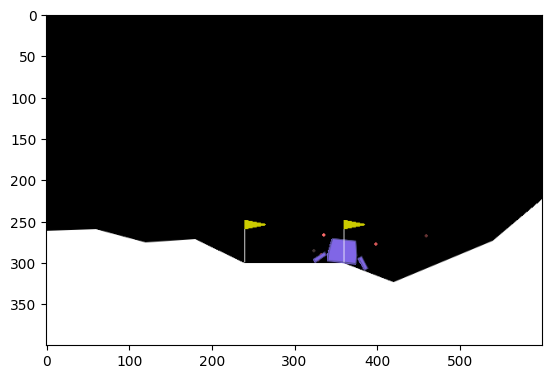

In [24]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [25]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

In [41]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)
        
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

In [39]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

In [45]:
agent.network.train()  # Switch network into training mode 
EPISODE_PER_BATCH = 5  # update the agent every 5 episodes
NUM_BATCH = 100        # totally update the agent for 500 times
GAMMA = 0.99           # discount factor for cumulative rewards

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        episode_log_probs, episode_rewards = [], []
        total_reward, total_step = 0, 0
        
        while True:
            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                # Calculate discounted cumulative rewards
                discounted_rewards = []
                running_add = 0
                # Reverse calculate discounted rewards
                for r in reversed(episode_rewards):
                    running_add = r + GAMMA * running_add
                    discounted_rewards.insert(0, running_add)
                
                # Store the episode data
                log_probs.extend(episode_log_probs)
                rewards.extend(discounted_rewards)
                
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

    # Normalize rewards within the batch
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)
    
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    
    # Update progress bar description
    prg_bar.set_description(f"Total: {avg_total_reward:4.1f}, Final: {avg_final_reward:4.1f}, Max: {max(total_rewards):4.1f}, Min: {min(total_rewards):4.1f}")
    
    # Update agent
    agent.learn(
        torch.stack(log_probs), 
        torch.from_numpy(rewards).float()
    )

  0%|          | 0/100 [00:00<?, ?it/s]

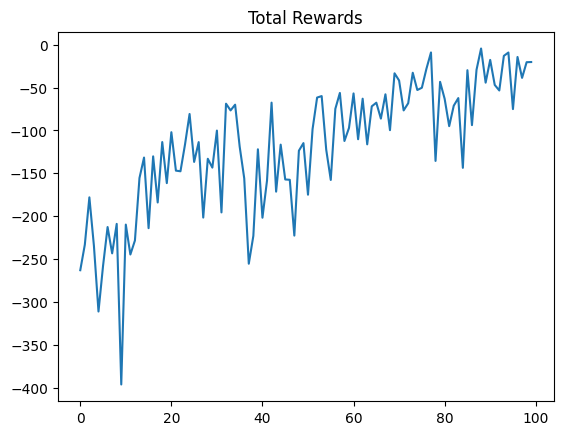

In [46]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

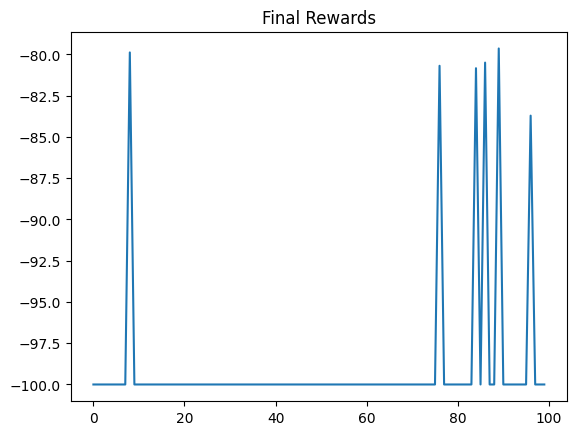

In [47]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

-26.44063879735451


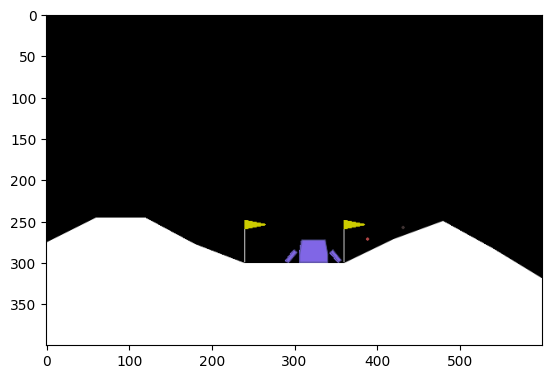

In [49]:
fix(env, seed)
agent.network.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


In [50]:
print(np.mean(test_total_reward))

-31.314049877709408


In [51]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[2, 2, 0, 0, 2, 3, 3, 2, 2, 3, 0, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 2, 1, 2, 3, 0, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 1, 3, 3, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 3, 0, 2, 2, 3, 1, 2, 1, 0, 2, 1, 1, 1, 0, 2, 2, 3, 2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 3, 2, 2, 1, 2, 3, 2, 1, 0, 2, 1, 3, 3, 3, 1, 1, 2, 3, 2, 0, 2, 1, 2, 2, 3, 3, 3, 2, 3, 1, 0, 2, 2, 0, 2, 1, 3, 2, 0, 2, 2, 3, 2, 0, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 3, 3, 1, 3, 2, 0, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 3, 2, 3, 0, 3], [3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 3, 2, 3, 3, 2, 2, 0, 0, 1, 2, 2, 3, 0, 1, 0, 2, 2, 0, 3, 2, 2, 0, 3, 2, 3, 2, 0, 2, 2, 2, 2, 2, 3, 1, 2, 3, 2, 2, 3, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3, 3, 2, 2, 2, 1, 2, 2, 1, 2, 3, 0, 2, 3, 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [52]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{2: 471, 0: 101, 3: 182, 1: 161}


In [57]:
import numpy as np

PATH = "Action_List.npy"
# 创建对象数组来存储不同长度的列表
action_array = np.empty(len(action_list), dtype=object)
for i, sublist in enumerate(action_list):
    action_array[i] = sublist

np.save(PATH, action_array)

In [59]:
import os
os.system(f'zip {PATH}.zip {PATH}')  # 先压缩（可选）
from IPython.display import FileLink
FileLink(f'{PATH}.zip')

  adding: Action_List.npy (deflated 71%)


/kaggle/working/Action_List.npy.zip

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Your reward is : -60.71
Your reward is : -20.57
Your reward is : -36.35
Your reward is : -12.50
Your reward is : -26.44


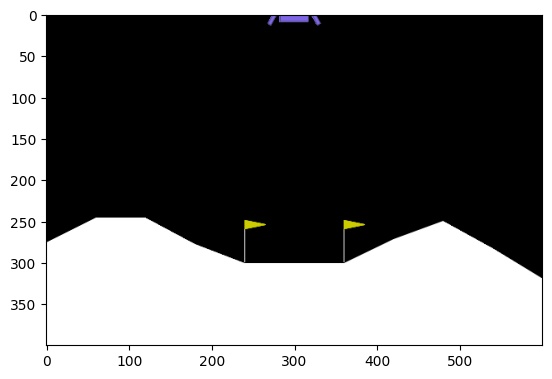

In [60]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

In [61]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -31.31
